In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt


file_path = '/Users/yunustopcu/Documents/GitHub/predictive-solar-supply-chain/power_usage_2016_to_2020.csv'
data = pd.read_csv(file_path)


In [14]:
data.head(5)


,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [15]:
from datetime import datetime

# Define a function to check if the date is in the expected format
def check_date_format(date_string):
    try:
        # If the date can be parsed in the expected format, it's consistent
        datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
        return True
    except ValueError:
        # If parsing fails, the format is inconsistent
        return False

# Apply the check to the 'StartDate' column
date_format_consistency = data['StartDate'].apply(check_date_format)

# Check if there are any False values in the results, indicating inconsistencies
inconsistencies = not date_format_consistency.all()

# Count the number of inconsistent dates, if any
inconsistent_dates_count = len(data[~date_format_consistency])

inconsistencies, inconsistent_dates_count


(False, 0)

In [16]:
# To find the first and last date in the dataset, we'll convert the 'StartDate' column to datetime format and then find the minimum and maximum dates.

# Convert 'StartDate' to datetime format
#data['StartDate'] = pd.to_datetime(data['StartDate'])

n = data.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = n))
data['StartDate'] = p1.to_frame().index


# Find the first (minimum) and last (maximum) date
first_date = data['StartDate'].min()
last_date = data['StartDate'].max()

first_date, last_date

# DEBUGGING LINE, DONT BOTHER
#data.to_csv('data.csv', index=False)



(Period('2016-06-01 00:00', 'H'), Period('2020-07-07 23:00', 'H'))

In [17]:
# To trim the dataset to only include data from 2017-01-01 to 2018-01-01, we'll filter the 'StartDate' to be within this range.

start_date = '2017-01-01'
end_date = '2018-01-01'

# Filter the dataset for the given date range
trimmed_data = data[(data['StartDate'] >= start_date) & (data['StartDate'] <= end_date)]

# Check the first few rows to ensure the trimming was successful
trimmed_data.head(), trimmed_data.tail()


(             StartDate  Value (kWh)  day_of_week    notes
 5136  2017-01-01 00:00        0.840            6  weekend
 5137  2017-01-01 01:00        0.731            6  weekend
 5138  2017-01-01 02:00        0.254            6  weekend
 5139  2017-01-01 03:00        0.270            6  weekend
 5140  2017-01-01 04:00        0.318            6  weekend,
               StartDate  Value (kWh)  day_of_week    notes
 13892  2017-12-31 20:00        0.306            6  weekend
 13893  2017-12-31 21:00        0.287            6  weekend
 13894  2017-12-31 22:00        0.266            6  weekend
 13895  2017-12-31 23:00        0.284            6  weekend
 13896  2018-01-01 00:00        0.448            0  weekday)

In [18]:
# Convert 'StartDate' from PeriodDtype to datetime
trimmed_data['StartDate'] = trimmed_data['StartDate'].dt.to_timestamp()
trimmed_data['StartDate'] = pd.to_datetime(trimmed_data['StartDate'])
trimmed_data.set_index('StartDate', inplace=True)
trimmed_data = trimmed_data.asfreq('H', method='ffill')  # Ensure hourly frequency, filling any missing values
def fit_predict_ets(data, beginning, training_end, prediction_length):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Ensure beginning and training_end are pandas Timestamp for consistency
    beginning = pd.to_datetime(beginning)
    training_end = pd.to_datetime(training_end)
    
    # Slice the data for training based on beginning and training_end
    training_data = data.loc[beginning:training_end]
    
    # Fit the model on the training data
    model = ExponentialSmoothing(training_data, seasonal='add', seasonal_periods=24).fit()
    
    # Forecast
    forecast_start = training_end + pd.Timedelta(hours=1)
    forecast_end = forecast_start + pd.Timedelta(hours=prediction_length - 1) # Adjusting to include the correct number of periods
    forecast = model.predict(start=forecast_start, end=forecast_end)
    
    # Plot the entire dataset from beginning to training_end, and forecast data
    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[beginning:training_end], label='Historical Data')
    plt.plot(forecast, label='Forecast', linestyle='--')
    plt.title("ETS Model Forecast vs Actual")
    plt.legend()
    plt.show()
    
    # Ensure the forecast index aligns with the actual data for MAPE calculation
    actual = data.loc[forecast.index]
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mape



/var/folders/p5/4gqxjwtd7k73wdww84v63q9c0000gn/T/ipykernel_3381/3635391145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['StartDate'] = trimmed_data['StartDate'].dt.to_timestamp()
/var/folders/p5/4gqxjwtd7k73wdww84v63q9c0000gn/T/ipykernel_3381/3635391145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['StartDate'] = pd.to_datetime(trimmed_data['StartDate'])


In [19]:
trimmed_data.head()

,Value (kWh),day_of_week,notes
StartDate,,,
2017-01-01 00:00:00,0.840,6,weekend
2017-01-01 01:00:00,0.731,6,weekend
2017-01-01 02:00:00,0.254,6,weekend
2017-01-01 03:00:00,0.270,6,weekend
2017-01-01 04:00:00,0.318,6,weekend


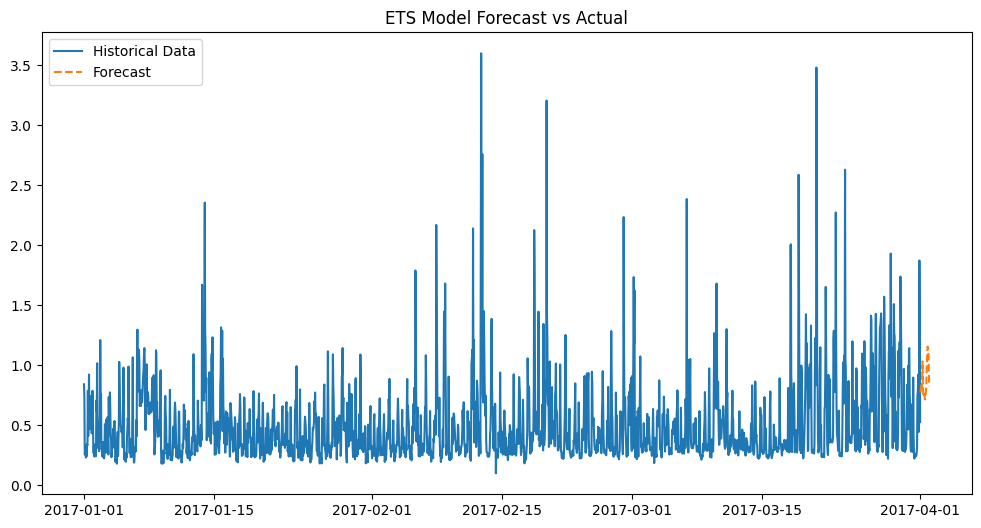

MAPE for 3 months training: 112.51%


In [20]:
# Determine the overall end of the data to calculate different training starts
overall_start_of_data = trimmed_data.index.min()

# 1) For 3 months data to predict the next 24 hours
beginning_of_training_3m = overall_start_of_data
end_of_training_3m = overall_start_of_data + pd.Timedelta(days=90)
mape_3m = fit_predict_ets(trimmed_data['Value (kWh)'], beginning_of_training_3m, end_of_training_3m, 24)
print(f"MAPE for 3 months training: {mape_3m:.2f}%")


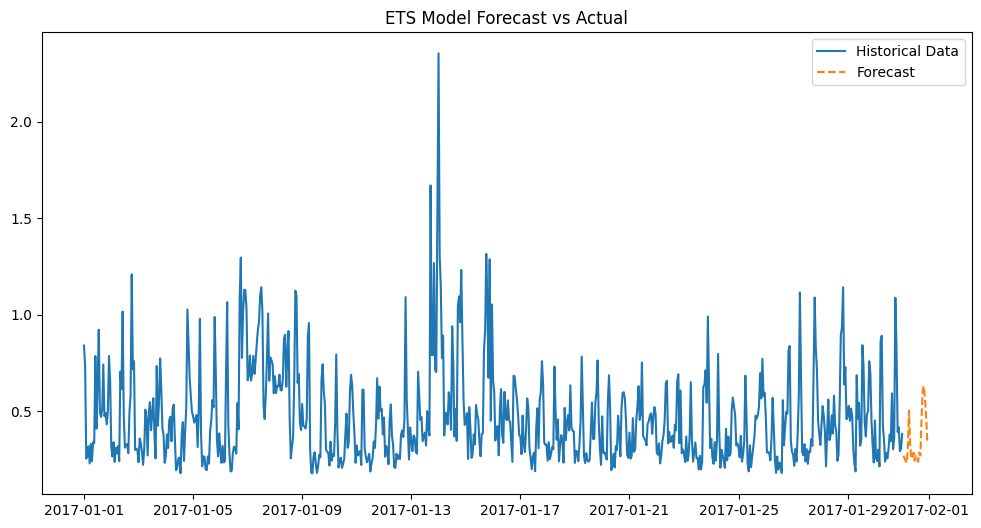

MAPE for 1 month training: 27.12%


In [21]:
# 2) For 1 month data to predict the next 24 hours
beginning_of_training_1m = overall_start_of_data
end_of_training_1m = overall_start_of_data + pd.Timedelta(days=30)
mape_1m = fit_predict_ets(trimmed_data['Value (kWh)'], beginning_of_training_1m, end_of_training_1m, 24)
print(f"MAPE for 1 month training: {mape_1m:.2f}%")


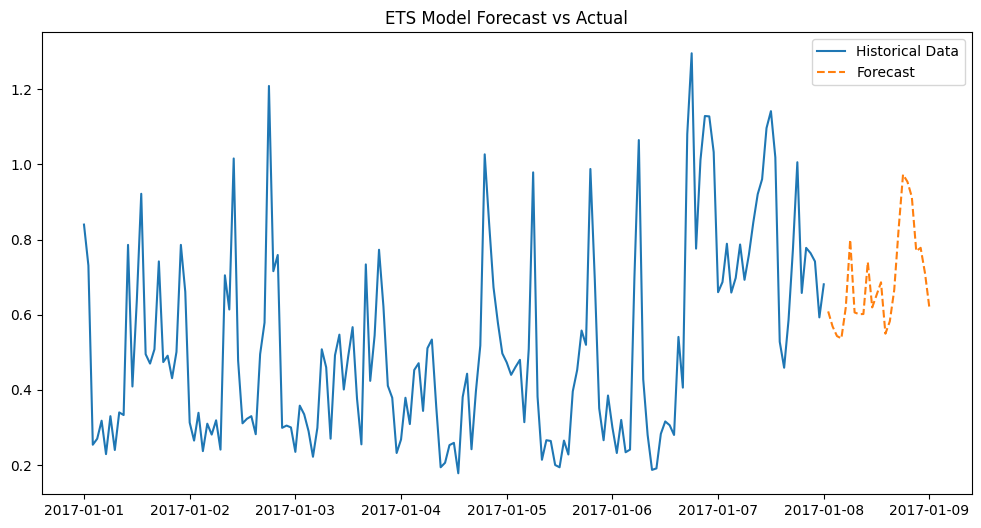

MAPE for 1 week training: 34.67%


In [22]:
# 3) For 1 week data to predict the next 24 hours
beginning_of_training_1w = overall_start_of_data
end_of_training_1w = overall_start_of_data + pd.Timedelta(days=7)
mape_1w = fit_predict_ets(trimmed_data['Value (kWh)'], beginning_of_training_1w, end_of_training_1w, 24)
print(f"MAPE for 1 week training: {mape_1w:.2f}%")


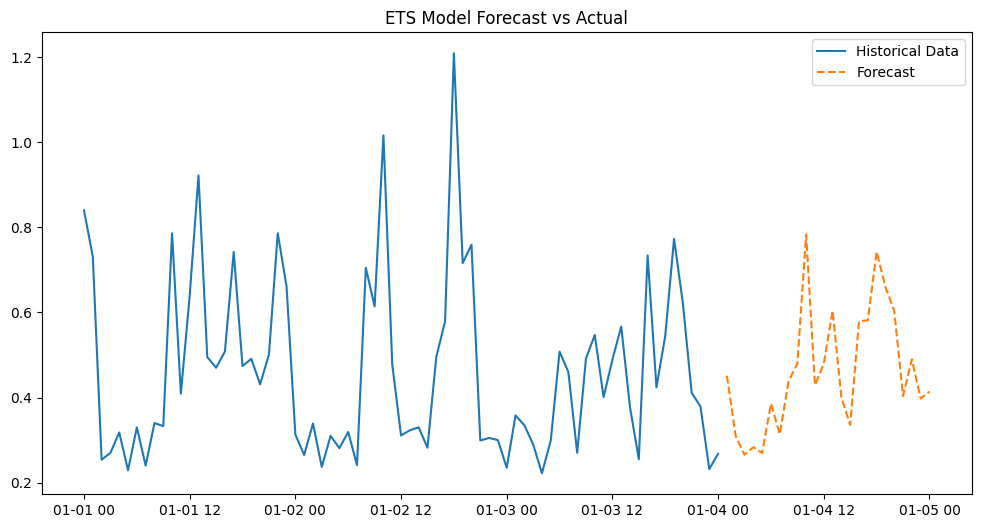

MAPE for 1 week training: 60.17%


In [23]:
# 4) For 3 days data to predict the next 24 hours
beginning_of_training_1w = overall_start_of_data
end_of_training_1w = overall_start_of_data + pd.Timedelta(days=3)
mape_1w = fit_predict_ets(trimmed_data['Value (kWh)'], beginning_of_training_1w, end_of_training_1w, 24)
print(f"MAPE for 1 week training: {mape_1w:.2f}%")


Epoch 1/20
67/67 [==============================] - 2s 9ms/step - loss: 0.0094
Epoch 2/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0081
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0076
Epoch 4/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0064
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0059
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 9/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 10/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 11/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 12/20
67/67 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 13/20
67/67 [==============================

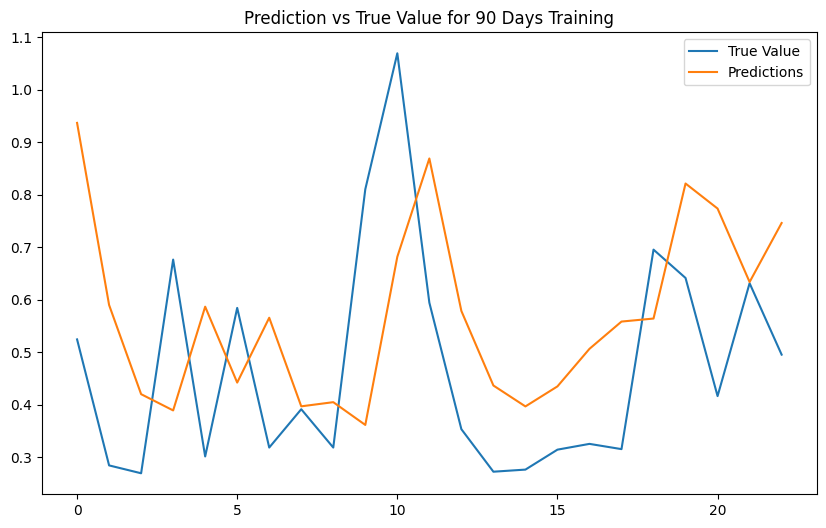

Epoch 1/20
22/22 [==============================] - 1s 8ms/step - loss: 0.0146
Epoch 2/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0107
Epoch 7/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 8/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 9/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0099
Epoch 10/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 11/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 12/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 13/20
22/22 [==============================

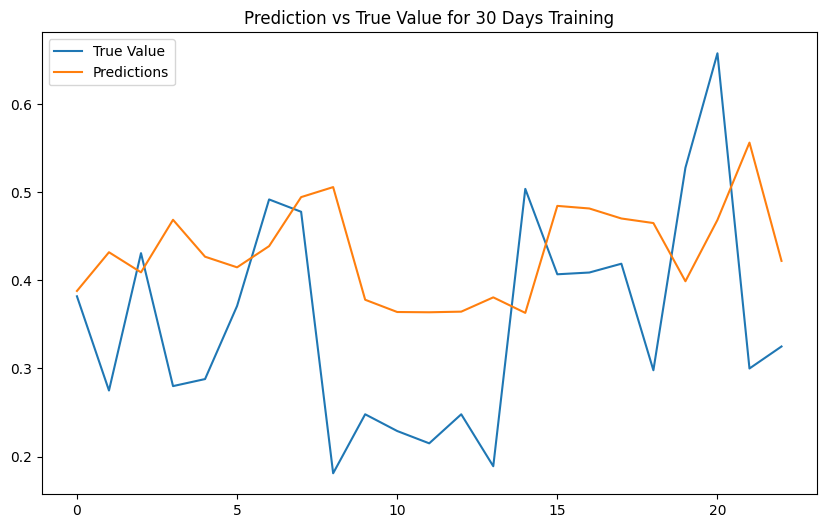

Epoch 1/20
5/5 [==============================] - 1s 9ms/step - loss: 0.1118
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0535
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0562
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0527
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0529
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0499
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0506
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0502
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0496
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0498
Epoch 11/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0492
Epoch 12/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0489
Epoch 13/20
5/5 [==============================] - 0s 7ms/step - loss: 0.

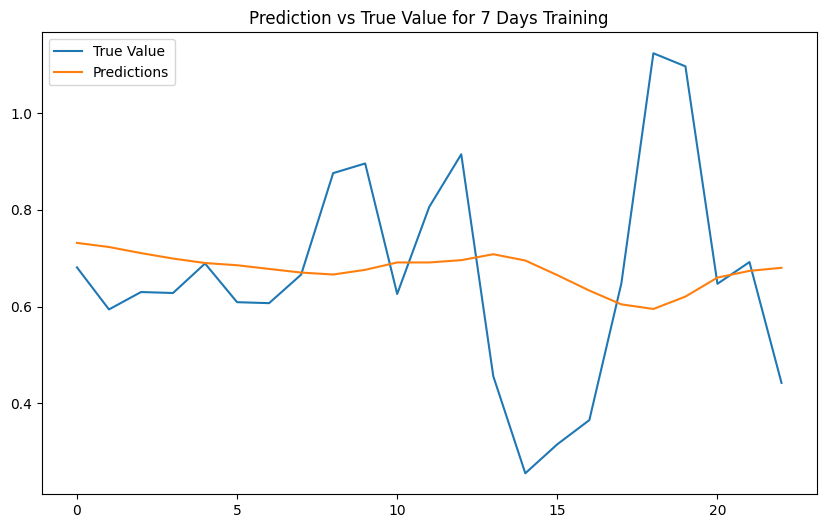

Epoch 1/20
2/2 [==============================] - 2s 12ms/step - loss: 0.1158
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0819
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0597
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0517
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0506
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0530
Epoch 7/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0515
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0499
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0485
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0486
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0494
Epoch 12/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0497
Epoch 13/20
2/2 [==============================] - 0s 8ms/step - loss

1/1 [==============================] - 0s 307ms/step
MAPE for 3 days training: 46.82%


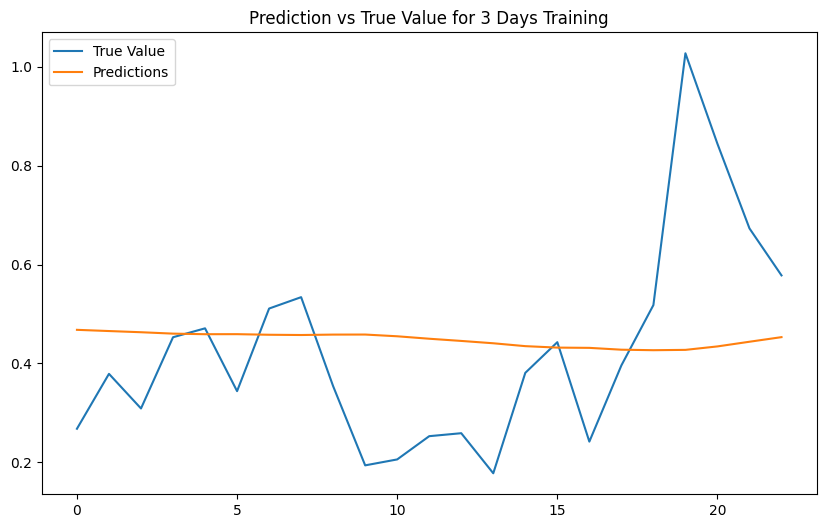

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Function to prepare the dataset for LSTM model
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

def lstm_prediction(trimmed_data, train_days):
    # Convert index to datetime if not already done
    if not isinstance(trimmed_data.index, pd.DatetimeIndex):
        trimmed_data.index = pd.to_datetime(trimmed_data.index)
        
    # Selecting the training data timeframe
    train_end = trimmed_data.index.min() + pd.Timedelta(days=train_days)
    test_end = train_end + pd.Timedelta(days=1)
    
    train_data = trimmed_data[trimmed_data.index < train_end]['Value (kWh)'].values
    test_data = trimmed_data[(trimmed_data.index >= train_end) & (trimmed_data.index < test_end)]['Value (kWh)'].values
    
    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    
    # Create the dataset for LSTM
    look_back = 24  # considering 24 hours pattern
    X_train, Y_train = create_dataset(train_data_scaled, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Fit the model
    model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)
    
    # Preparing test data
    test_data_scaled = scaler.transform(test_data.reshape(-1, 1))
    X_test, _ = create_dataset(np.append(train_data_scaled[-look_back:], test_data_scaled).reshape(-1, 1), look_back)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Making predictions
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    
    # Calculating MAPE
    mape = mean_absolute_percentage_error(test_data[:len(predictions_rescaled)], predictions_rescaled)
    print(f'MAPE for {train_days} days training: {mape*100:.2f}%')
    
    # Plotting the results
    plt.figure(figsize=(10,6))
    plt.plot(test_data[:len(predictions_rescaled)], label='True Value')
    plt.plot(predictions_rescaled, label='Predictions')
    plt.legend()
    plt.title(f'Prediction vs True Value for {train_days} Days Training')
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import timedelta

def train_and_predict(df, train_days):
    df.index = pd.to_datetime(df.index)
    
    # Add temporal features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    
    end_date_train = df.index.min() + timedelta(days=train_days)

    train_data = df[df.index < end_date_train]
    test_data = df[(df.index >= end_date_train) & (df.index < end_date_train + timedelta(hours=24))]

    X_train = train_data.drop('Value (kWh)', axis=1)
    y_train = train_data['Value (kWh)']
    X_test = test_data.drop('Value (kWh)', axis=1)
    y_test = test_data['Value (kWh)']

    X_train_encoded = pd.get_dummies(X_train, columns=['day_of_week', 'notes'])
    X_test_encoded = pd.get_dummies(X_test, columns=['day_of_week', 'notes'])

    X_test_encoded, X_train_encoded = X_test_encoded.align(X_train_encoded, join='left', axis=1, fill_value=0)

    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
    model.fit(X_train_encoded, y_train)

    predictions = model.predict(X_test_encoded)

    mape = mean_absolute_percentage_error(y_test, predictions)
    print(f'MAPE: {mape * 100:.2f}%')

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted', color='red')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value (kWh)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mape


MAPE: 38.85%


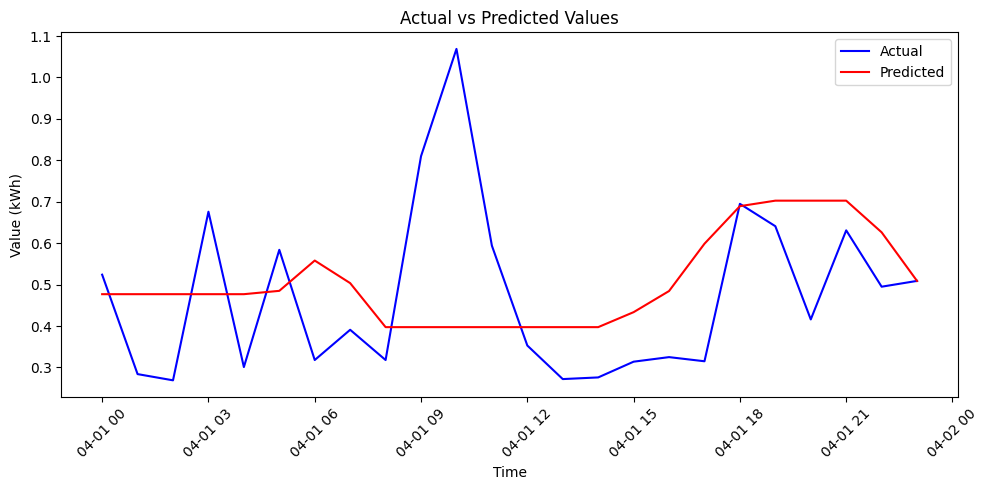

MAPE: 47.29%


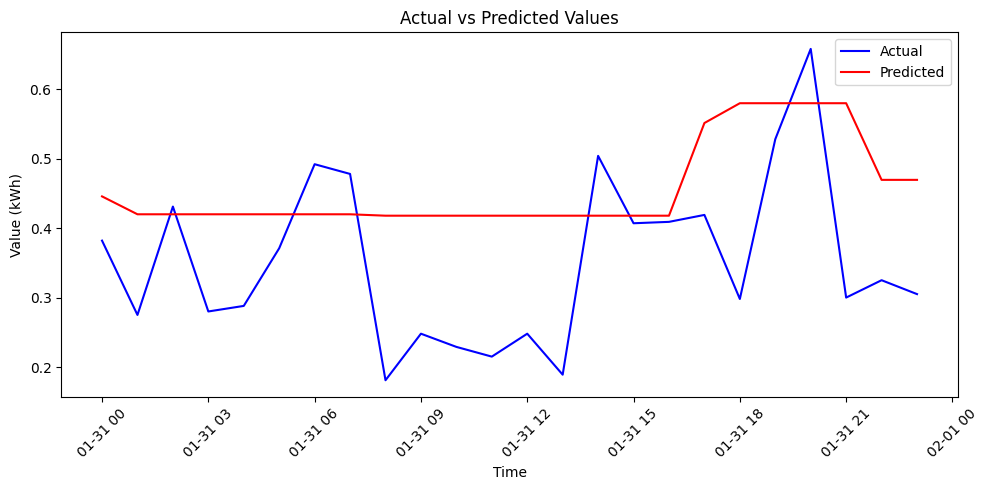

MAPE: 32.67%


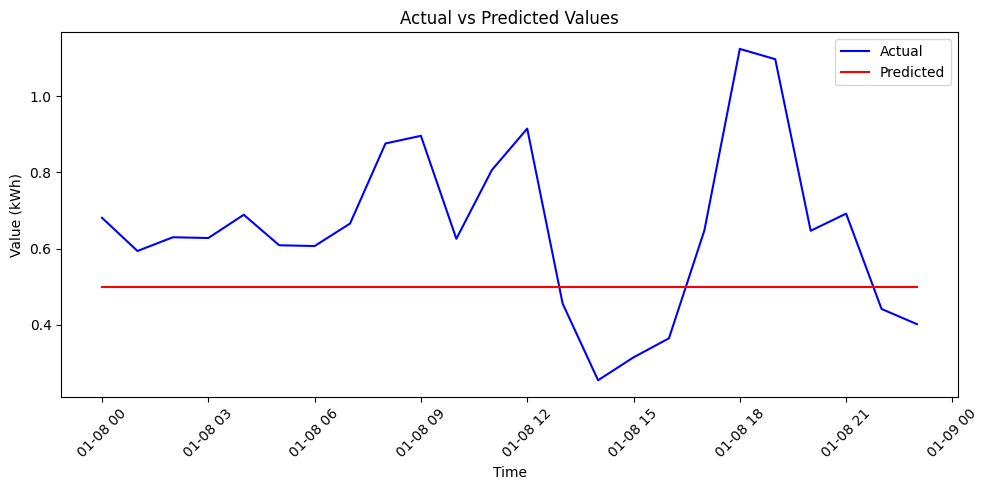

MAPE: 53.18%


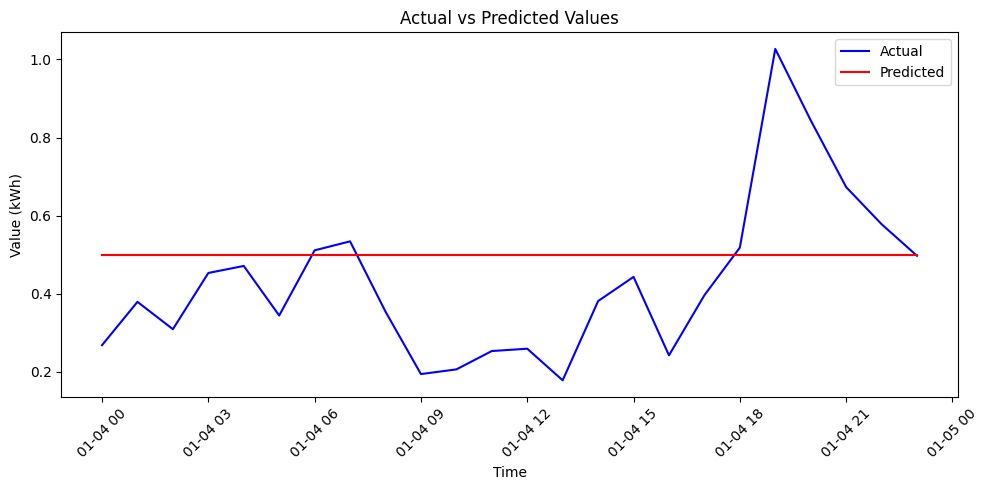

0.5317932935965468

In [ ]:
# Sample call to the function, assuming your DataFrame is named trimmed_data
# Note: You need to preprocess your dataframe to convert 'day_of_week' and 'notes' into a format that can be used by the model.
# Convert 'day_of_week' to categorical type
trimmed_data['day_of_week'] = trimmed_data['day_of_week'].astype('category')
# 'notes' is already in a suitable format

# Call the function with different training durations
# For the first 3 months (roughly 90 days)
train_and_predict(trimmed_data, 90)
# For the first month
train_and_predict(trimmed_data, 30)
# For the first week
train_and_predict(trimmed_data, 7)
# For the first 3 days
train_and_predict(trimmed_data, 3)


In [ ]:
# 4) For 3 days data to predict the next 24 hours
beginning_of_training_3d = overall_start_of_data
end_of_training_3d = overall_start_of_data + pd.Timedelta(days=30)
mape_3d_autoarima = fit_predict_autoarima(trimmed_data['Value (kWh)'], beginning_of_training_3d, end_of_training_3d, 24)
print(f"MAPE for 3 days training with AutoARIMA: {mape_3d_autoarima:.2f}%")
